# Advanced Data Manipulation II: "I Love Group-By"

In this lecture, we'll work on some additional skills for manipulating and analyzing tabular data. Our focus will be on: 

- **Filtering** data, identifying specific rows according to complex criteria. 
- **Aggregating** data, computing complicated summaries of groups. 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Let's start by reading in some data. We'll use the SQLite database that we created in a [recent lecture](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16B/blob/master/lectures/sql/sql-1.ipynb) for this purpose. You may need to run the code in that lecture in order for the following block to correctly read in the data. Make sure that the string supplied to `sqlite3.connect()` points to the location of the database. 

We are going to extract measurements for stations south of -80 degrees latitude. 

In [2]:
conn = sqlite3.connect("../sql/temps.db") 

cmd = \
"""
SELECT S.name, T.year, T.month, T.temp
FROM temperatures T
LEFT JOIN stations S ON T.id = S.id
WHERE S.latitude < -80
"""

df = pd.read_sql_query(cmd, conn)
conn.close()

# equivalent (automatically handles closing): 

# with sqlite3.connect("../sql/temps.db") as conn: 
#    df = pd.read_sql_query(cmd, conn)

### Takeaways for Today

1. The `transform()` and `apply()` methods can enable advanced computation on Pandas data frames using quite simple code. 
2. Pandas also offers specialized functions for common tasks, but getting the hang of `transform()` and `apply()` will take you far. 
3. Global warming is scary. 

## Grouped Summaries

We already know how to compute grouped summaries of the data using `pd.groupby().aggregate()`. For example, let's compute the mean temperature for each station within each month, averaged across years. Let's also compute the standard deviation and the number of observations. 

In [3]:
df.groupby(["NAME", "Month"])["Temp"].aggregate([np.mean, np.std, len])

mean       std   len
NAME           Month                           
AMUNDSEN_SCOTT 1     -27.894839  1.623436  62.0
               2     -40.524918  1.944692  61.0
               3     -53.653934  1.943314  61.0
               4     -57.389194  2.696554  62.0
               5     -57.731311  2.370763  61.0
...                         ...       ...   ...
THERESA        8     -29.309000  2.854964  20.0
               9     -28.089048  2.471694  21.0
               10    -23.256957  1.516552  23.0
               11    -16.888182  1.499434  22.0
               12    -11.063043  1.379418  23.0

[156 rows x 3 columns]

This is handy information, and it's convenient to be able to easily collect it in a summary table. However, there are some cases in which we may wish to compute new columns without creating a smaller summary table. Here's an example: 

## Temperature Anomaly Detection

Suppose we'd like to construct a list of unusually hot or cold months in our data set. For example, if February in 1995 is much warmer than average, we'd like to detect this. What makes a month "unusually hot or cold"? There are lots of valid ways to define this. How would you approach this? 

<br> <br> <br> <br> <br> 

For our first attempt, let's ask the following idea: 

> For each temperature reading, how does that reading compare to the average reading *in that month* and *at that measurement station*?

For example, if July in 2017 at Amundsen-Scott station was much warmer than the average July reading at that station, then we might say that July 2017 was anomalous. 

### Z-Scores

To make this concrete, let's say that a given month in a year is anomalous if it is more than two standard deviations away from the mean for that month. If you've taken a statistics class, this is the same as requiring that the *z-score* for that month is larger than 2 in absolute value. That is, we should compute:

$$z = \frac{\text{reading} - \text{average reading at station in month}}{\text{standard deviation at station in month}}$$

and ask whether $|z| > 2$. 

How to compute this? Well, we already know how to compute means and standard deviations using methods like our table above, but it's hard to make comparisons to individual months this way. Can you think of how you would perform such a computation in Python? 

<br> <br> <br> <br> <br> 

If you suggested that we `merge` the summary table from above to our original `df`, that would eventually work! But `merge` is a slow operation, and we can actually avoid it by using what are sometimes called *window functions.* A window function operates on grouped data, **without reducing the length of the data frame.** In `pandas`, the most general way to create window functions is by using the `transform()` method of data frames and series. For example: 

In [4]:
# compute the average temperature in each month for each station
# notice the length of the result! 
df.groupby(["NAME", "Month"])["Temp"].transform(np.mean)

0      -43.322500
1      -45.956667
2      -46.141667
3      -49.264545
4      -40.610000
          ...    
3647   -28.220667
3648   -22.973333
3649   -13.738571
3650    -7.522000
3651    -8.098000
Name: Temp, Length: 3652, dtype: float64

Compare this to:

In [5]:
# note the length! 
df.groupby(["NAME", "Month"])["Temp"].aggregate(np.mean)

NAME            Month
AMUNDSEN_SCOTT  1       -27.894839
                2       -40.524918
                3       -53.653934
                4       -57.389194
                5       -57.731311
                           ...    
THERESA         8       -29.309000
                9       -28.089048
                10      -23.256957
                11      -16.888182
                12      -11.063043
Name: Temp, Length: 156, dtype: float64

Because the length of the output of `transform` is the same as that of the original data, we can use `transform` to create new columns. Here's a simple function to compute z-scores of an array: 

In [6]:
def z_score(x):
    m = np.mean(x)
    s = np.std(x)
    return (x - m)/s

Now we can compute the z-scores in one shot: 

In [7]:
df["z"] = df.groupby(["NAME", "Month"])["Temp"].transform(z_score)

Using `transform`, we can skip both computing the summary table and merging it later. We're now ready to find anomalous months in our data. Before we do, we're going to add a handy column to the original data for plotting purposes. We already saw this code in a [prior lecture](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16B/blob/master/lectures/EDA/pd-1.ipynb). 

In [8]:
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str))

Ok, now let's get a subset data frame with the temperature anomalies: 

In [9]:
anomalies = df[np.abs(df["z"]) > 2]
anomalies

,NAME,Year,Month,Temp,z,Date
5,BALDRICK_AWS,2008,11,-30.94,-2.396917,2008-11-01
39,BALDRICK_AWS,2012,7,-54.15,-2.205300,2012-07-01
47,BALDRICK_AWS,2013,3,-44.30,-2.043541,2013-03-01
50,BALDRICK_AWS,2013,6,-37.64,2.234982,2013-06-01
53,BALDRICK_AWS,2013,9,-42.40,2.233290,2013-09-01
...,...,...,...,...,...,...
3481,BRIANNA,1996,4,-19.56,2.101606,1996-04-01
3504,BRIANNA,2001,1,-12.35,-2.637769,2001-01-01
3521,BRIANNA,2002,9,-21.42,2.288587,2002-09-01
3543,BRIANNA,2004,7,-39.41,-2.291598,2004-07-01


We can now, for example, plot these anomalies for a given station: 

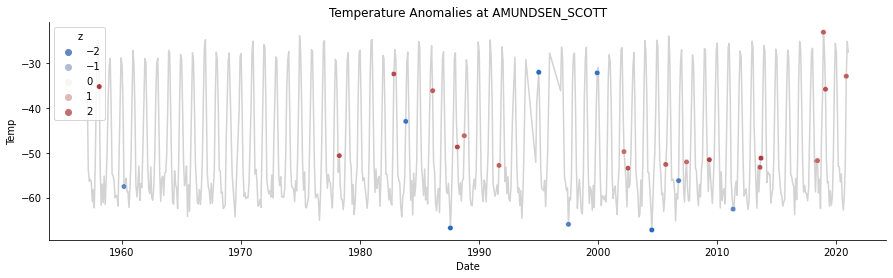

In [23]:
station = "AMUNDSEN_SCOTT"

import seaborn as sns

fig = plt.subplots(figsize = (15, 4))

sns.lineplot(data = df[df["NAME"] == station], 
             x = "Date", 
             y = "Temp",
             color = "lightgrey")

sns.scatterplot(data = anomalies[anomalies["NAME"] == station], 
                x = "Date", 
                y = "Temp", 
                zorder = 100, # show the dots on top
                hue = "z",
                s = 30, 
                palette = "vlag")

plt.gca().set(title = f"Temperature Anomalies at {station}")
sns.despine()

It looks like the rate of anomalies is increasing with time -- yikes. Predictably, most of the anomalies are anomalously *warm*. 

### Max and Min (Optional)

That approach works fine, but suppose now that we'd like to try things a different approach: we want to compute the warmest and coldest instances of each month on record. For example, we'd like to answer questions like: 

> *In what year did Amundsen-Scott Station record the warmest February, on average?* 

One approach to this is to define a function to compute rankings on individual subsets, and invoke it using `transform()`. For example: 

In [84]:
# feel free to look up np.argsort() and think about why this works
def my_rank(x):
    return x.argsort().argsort()

In [88]:
# use the new function to create rankings
df["rank"] = df.groupby(["NAME", "Month"])["Temp"].transform(my_rank)

In [101]:
# coldest months on record
coldest = df[df["rank"] == 0]
coldest

,NAME,Year,Month,Temp,z,Date,rank,max_rank
2,BALDRICK_AWS,2008,6,-50.70,-1.198329,2008-06-01,0,11
4,BALDRICK_AWS,2008,10,-43.66,-1.435409,2008-10-01,0,11
5,BALDRICK_AWS,2008,11,-30.94,-2.396917,2008-11-01,0,11
6,BALDRICK_AWS,2008,12,-20.55,-1.592334,2008-12-01,0,11
8,BALDRICK_AWS,2009,2,-31.39,-1.940738,2009-02-01,0,11
...,...,...,...,...,...,...,...,...
3572,BRIANNA,2006,12,-10.05,-1.726363,2006-12-01,0,14
3586,BRIANNA,2008,8,-38.94,-1.671499,2008-08-01,0,14
3592,BRIANNA,2009,2,-19.51,-2.247747,2009-02-01,0,16
3623,BRIANNA,2011,9,-32.46,-1.426637,2011-09-01,0,14


There's a bit of a sticky point here: it's easy to get the *coldest* months on record this way, because they all have the same rank (0). However, getting the *warmest* months is a little trickier, because they have different ranks (due to some stations not having data in all years or months): 

In [102]:
df.groupby(["NAME", "Month"])["rank"].max()

NAME            Month
AMUNDSEN_SCOTT  1        61
                2        60
                3        60
                4        61
                5        60
                         ..
THERESA         8        19
                9        20
                10       22
                11       21
                12       22
Name: rank, Length: 156, dtype: int64

How can we extract the warmest months? We can use `transform()` again! 

In [103]:
df["max_rank"] = df.groupby(["NAME", "Month"])["rank"].transform(np.max)

In [104]:
warmest = df[df["rank"] == df["max_rank"]]
warmest

,NAME,Year,Month,Temp,z,Date,rank,max_rank
13,BALDRICK_AWS,2009,7,-45.23,1.821199,2009-07-01,10,10
19,BALDRICK_AWS,2010,1,-17.84,1.238271,2010-01-01,12,12
24,BALDRICK_AWS,2011,2,-26.68,1.806802,2011-02-01,11,11
50,BALDRICK_AWS,2013,6,-37.64,2.234982,2013-06-01,11,11
53,BALDRICK_AWS,2013,9,-42.40,2.233290,2013-09-01,9,9
...,...,...,...,...,...,...,...,...
3624,BRIANNA,2011,10,-19.91,1.688591,2011-10-01,14,14
3625,BRIANNA,2011,11,-11.38,1.316614,2011-11-01,13,13
3631,BRIANNA,2012,5,-22.45,1.463663,2012-05-01,15,15
3638,BRIANNA,2012,12,-4.72,1.913476,2012-12-01,14,14


## Other Approaches

Many tasks in `pandas` can be performed in more than one way. In this lecture so far, I've focused on the `transform` method of grouped data frames, which is extraordinarily flexible and can be used for many purposes. However, there are also specialized methods that you may wish to research on your own time. For example, Pandas offers a [dedicated ranking method](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.rank.html), as well as a [dedicated filtering](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.filter.html) method. If you find yourself needing to perform many ranking or filtering operations, learning these methods may be a good use of your time. 

# Custom Aggregation

Earlier in this lecture, we reviewed an example of how to compute aggregates like means and standard deviations using `aggregate`. Here it is again: 

In [105]:
df.groupby(["NAME", "Month"])["Temp"].aggregate([np.mean, np.std, len])

mean       std   len
NAME           Month                           
AMUNDSEN_SCOTT 1     -27.894839  1.623436  62.0
               2     -40.524918  1.944692  61.0
               3     -53.653934  1.943314  61.0
               4     -57.389194  2.696554  62.0
               5     -57.731311  2.370763  61.0
...                         ...       ...   ...
THERESA        8     -29.309000  2.854964  20.0
               9     -28.089048  2.471694  21.0
               10    -23.256957  1.516552  23.0
               11    -16.888182  1.499434  22.0
               12    -11.063043  1.379418  23.0

[156 rows x 3 columns]

That's fun, but we can also compute *custom aggregates* using any function we want that takes in a series of numbers and spits out a new number. This is a very powerful ability, especially if you try get a little creative with it! The `apply` method is usually the way to go. For example, let's compute a simple estimate of the **year-over-year average change in temperature** in each month at each station. For this, we'll use our old friend, linear regression. We'll use the statistical fact that, when regressing `Temp` against `Year`, the coefficient of `Year` will be an estimate of the yearly change in `Temp`. 

In [35]:
from sklearn.linear_model import LinearRegression

def coef(data_group):
    x = data_group[["Year"]] # 2 brackets because X should be a df
    y = data_group["Temp"]   # 1 bracket because y should be a series
    LR = LinearRegression()
    LR.fit(x, y)
    return LR.coef_[0]

Although this might look a bit strange as a function for using `apply` (wasn't this from the machine learning part of the class?), it's a perfectly good way to compute data summaries, as it takes in two data columns and spits out a number. 

In [36]:
coefs = df.groupby(["NAME", "Month"]).apply(coef)

coefs = coefs.reset_index()
coefs

,NAME,Month,0
0,AMUNDSEN_SCOTT,1,0.009827
1,AMUNDSEN_SCOTT,2,-0.006219
2,AMUNDSEN_SCOTT,3,0.021752
3,AMUNDSEN_SCOTT,4,0.004177
4,AMUNDSEN_SCOTT,5,0.005560
...,...,...,...
151,THERESA,8,0.156196
152,THERESA,9,-0.020949
153,THERESA,10,0.031716
154,THERESA,11,0.035552


At what proportion of station/months is the temperature rising? 

In [37]:
(coefs[0] > 0).mean() # uh oh

0.5961538461538461

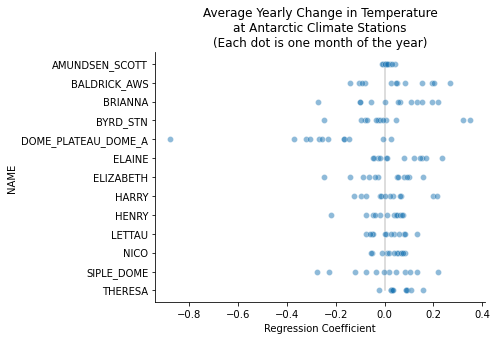

In [38]:
sns.relplot(data = coefs, 
            x = 0, 
            y = "NAME",
            alpha = 0.5, 
            height = 4,
            aspect = 1.7)
plt.plot([0,0], [0,12], color = "lightgray", zorder = 0)
labs = plt.gca().set(xlabel = "Regression Coefficient",
                     title = "Average Yearly Change in Temperature\nat Antarctic Climate Stations\n(Each dot is one month of the year)")

### Takeaways for Today

1. The `transform()` and `apply()` methods can enable advanced computation using simple code. 
2. Pandas also offers specialized functions for common tasks, but getting the hang of `transform()` and `apply()` will take you far. 
3. Global warming is scary. 